In [1]:
%cd ..

D:\dev\bayes-crm


D:\dev\bayes-crm\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import scipy.stats as st
from crm.levy_processes import *
from crm.crm_approx import *
from crm.fk import *
from crm.utils.general_utils import measure_time_process
from crm.utils.levy_process_utils import *
from crm.two_piece_envelope import two_envelope_beta
from tqdm import tqdm

plt.style.use("bmh")

# Conceptual illustration of the proposed method

Figure 1 in the paper.

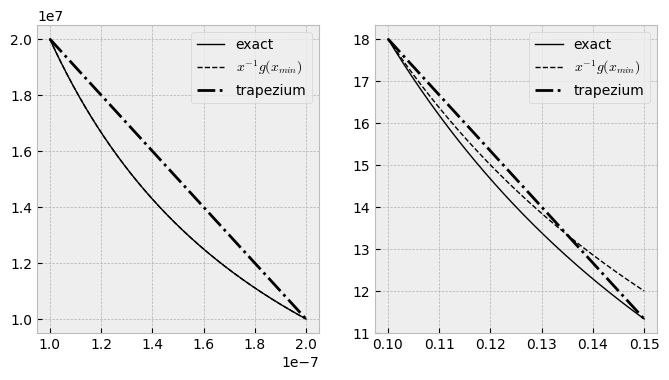

In [12]:
c = 2
m = 1
sigma = 0
ranges = [(1e-7, 2e-7), (0.1, 0.15)]  # [(lower1, upper1), (lower2, upper2)]
filename = "integration.pdf"
plot_beta_process({"c": c, "m": m}, ranges, filename, is_stable=False)

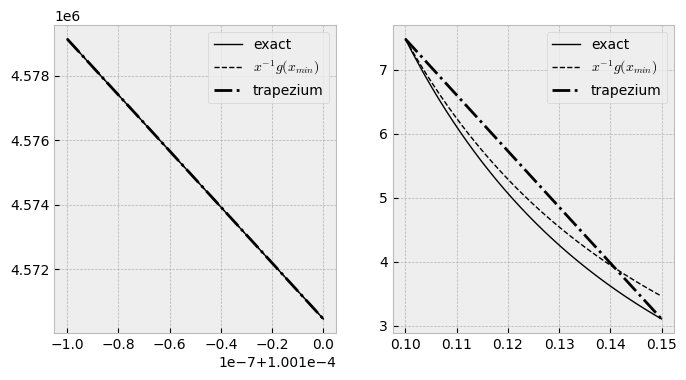

In [14]:
c = 2
m = 1
sigma = 0.9
ranges = [(1e-4, 1.001e-4), (0.1, 0.15)]  # [(lower1, upper1), (lower2, upper2)]
filename = "integration_beta_stable.pdf"
plot_beta_process({"c": c, "m": m, "sigma": sigma}, ranges, filename, is_stable=True)

In [5]:
c = 2
m = 1
xs = np.linspace(0, 80, 5001, endpoint=True)

p_trap = ApproxProcess(beta_process(m, c), 1001)
p_mix = ApproxProcess(beta_process(m, c), 1001, g_beta_process(m, c), -1)
p_prec = ApproxProcess(beta_process(m, c), 10000001)
interp_points = p_mix.generate(xs)
interp_points_trapezium = p_trap.generate(xs)
interp_points_prec = p_prec.generate(xs)
c_sum = p_mix.c_sum
c_sum_trapezium = p_trap.c_sum
c_sum_prec = p_prec.c_sum
edges = p_mix.edges
edges_prec = p_prec.edges

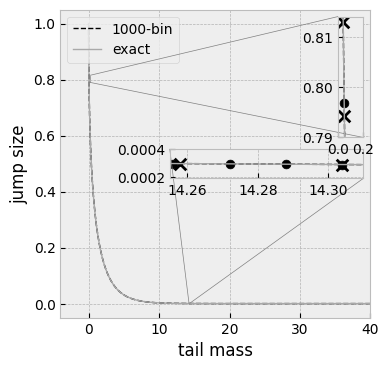

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

def create_inset(ax, zoom, loc, c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, xlim, ylim):
    axins = zoomed_inset_axes(ax, zoom, loc=loc)
    axins.plot(c_sum, edges[:-1][::-1], ls="--", lw=1, c="black") 
    axins.scatter(c_sum, edges[:-1][::-1], marker="x", s=70, c="black")
    axins.scatter(xs, interp_points, c="black", s=40, marker="o")
    axins.plot(c_sum_prec, edges_prec[1:][::-1], c="darkgrey", lw=1)
    axins.set_xlim(*xlim)
    axins.set_ylim(*ylim)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

fig, ax = plt.subplots(figsize=(4, 4))

(ln1,) = ax.plot(c_sum, edges[:-1][::-1], ls="--", lw=1, c="black")
(ln2,) = ax.plot(c_sum_prec, edges_prec[:-1][::-1], lw=1, c="darkgrey")
ax.legend([ln1, ln2], [r"1000-bin", "exact"], loc=2)

create_inset(ax, 500, "center right", c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, (14.255, 14.31), (0.00019, 0.0004))
create_inset(ax, 18, "upper right", c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, (0, 0.2), (0.79, 0.814))

ax.set_ylabel("jump size")
ax.set_xlabel("tail mass")
ax.set_xlim(None, 40)

fig.savefig("klass-ferg_1.pdf", bbox_inches="tight")

# Process speed vs number of grid points

This section contains the code for measuring the speed of the beta process simulated using the proposed algorithm with a different number of grid points.

In [24]:
m = 1  # mass parameter of the beta process
c = 2  # concentration parameter of the beta process
sigma = 0.5  # scale parameter of the stable beta process

In [25]:
num_fits = 1000 # number of fits for each experiment

## Beta process

In [ ]:
my_time = {}
# steps = 10**(np.power(10.0,np.arange(-6, -1, 1)[::-1])) np.logspace()
for n in tqdm(np.logspace(np.log10(100), np.log10(10**6), 11, endpoint=True, base=10) + 1):
    #my_time[n] = measure_time_approx_process(num_fits, beta_process(m, c), n, g_beta_process(m, c), -1, size=100, thr=0.5)  # decomposition provided
    my_time[n] = measure_time_approx_process(num_fits, beta_process(m, c), n,  size=100)  # decomposition not provided

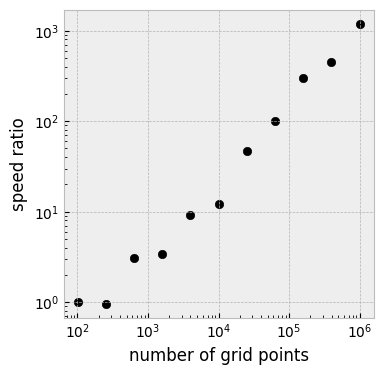

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(np.array(list(my_time.keys())), np.array(list(my_time.values())) / my_time[list(my_time.keys())[0]], marker="o", c="black")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("number of grid points")
ax.set_ylabel("speed ratio")
fig.savefig("beta_process_speed_vs_grid_size.pdf", bbox_inches="tight")

## Gamma process

In [ ]:
my_time = {}
num_fits = 1000
for n in tqdm(np.logspace(np.log10(100), np.log10(10**6), 11, endpoint=True, base=10) + 1):
    #my_time[n] = measure_time_approx_process(num_fits, gamma_process(1), n, g_gamma_process(1), -1, size=100, thr=0.5, bounds=(1e-10, np.inf))  # approximate the beta process with mixed method
    my_time[n] = measure_time_approx_process(num_fits, gamma_process(1), n_grids=n, size=100, bounds=(0, np.inf))

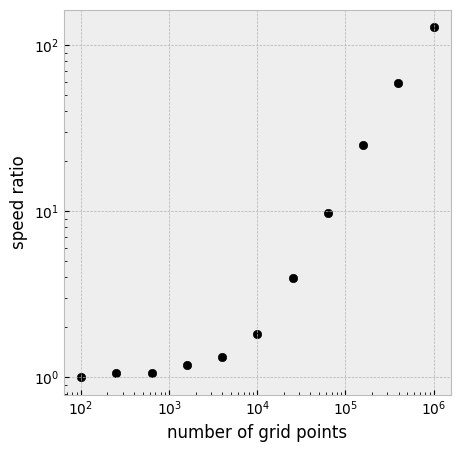

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(np.array(list(my_time.keys())), np.array(list(my_time.values())) / my_time[list(my_time.keys())[0]], marker="o", c="black")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("number of grid points")
ax.set_ylabel("speed ratio")
fig.savefig("gamma_process_speed_vs_grid_size.pdf", bbox_inches="tight")

# Error Analysis

## Relative jump size errors

Compare relative absolute error of the simulated process jumps (as measured versus "exact" Fergusson-Klass jumps) for different number of grid points.

### Beta Process

In [42]:
np.random.seed(0)
num_fits = 10
c = 2
m = 1
n_grids = [1001, 10001, 100001, 1000001]

In [43]:
errors_dec, errors_nodec, errors_approx, jump_sizes = process_errors_and_jump_sizes(num_fits, beta_process, {"m": m, "c": c}, n_grids, g_beta_process, use_trap=False, thr=0.5, cache=False, bounds=(0, 1))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### Relative jump size errors for the beta process with provided decomposition

$ e = |S_{\text{dec}} - S_{\text{FK}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

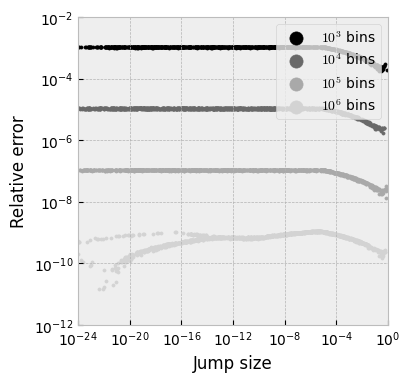

In [44]:
plot_errors_and_jump_sizes(jump_sizes, errors_dec, n_grids, "error_beta_m_1_c_2_thr_50_dec.pdf")

#### Relative jump size errors for the beta process without provided decomposition

$ e = |S_{\text{FK}} - S_{\text{nodec}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

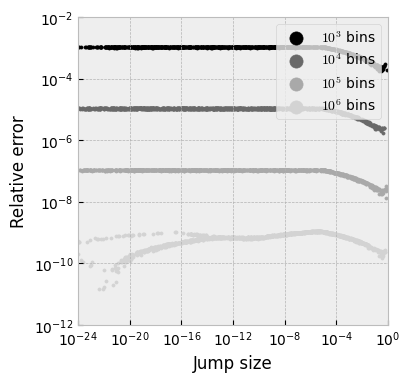

In [45]:
plot_errors_and_jump_sizes(jump_sizes, errors_nodec, n_grids, "error_beta_m_1_c_2_thr_50_nodec.pdf")

#### Relative jump size errors beyween the beta process with and without provided decomposition

$ e = |S_{\text{dec}} - S_{\text{nodec}}| / S_{\text{FK}}$

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:209: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

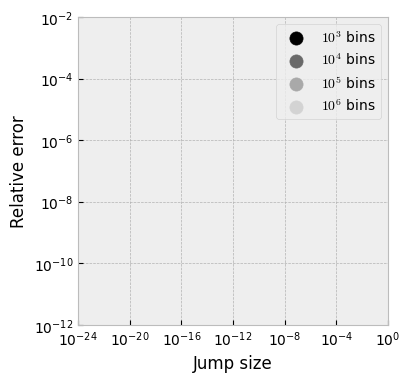

In [46]:
plot_errors_and_jump_sizes(jump_sizes, errors_approx, n_grids, "error_beta_m_1_c_2_thr_50_approx.pdf")

### Stable Beta Process

In [47]:
num_fits = 5
c = 2
m = 1
sigma = 0.1
n_grids = [1001, 10001, 100001, 1000001] # 1001, 10001, 100001,

In [48]:
errors_dec, errors_nodec, errors_approx, jump_sizes = process_errors_and_jump_sizes(num_fits, stable_beta_process, {"m": m, "c": c, "sigma": sigma}, n_grids, g_stable_beta_process, use_trap=False, thr=0.5, n_jumps=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

D:\dev\bayes-crm\crm\fk.py:115: RuntimeWarning: overflow encountered in exp
  return const1 * np.exp(-sigma * x + (c + sigma - 1) * np.log(1 - np.exp(x)))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

#### Relative jump size errors for the stable beta process with provided decomposition

$ e = |S_{\text{dec}} - S_{\text{FK}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

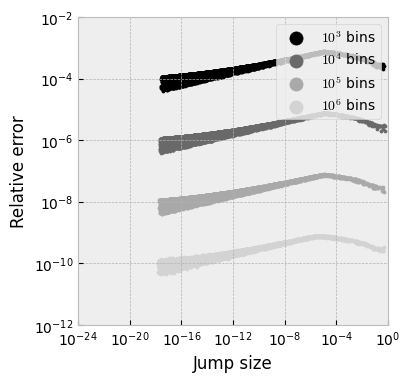

In [50]:
plot_errors_and_jump_sizes(jump_sizes, errors_dec, n_grids, "error_stable_beta_m_1_c_2_s_01_thr_50_dec.pdf") #

#### Relative jump size errors for the stable beta process without provided decomposition

$ e = |S_{\text{FK}} - S_{\text{nodec}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

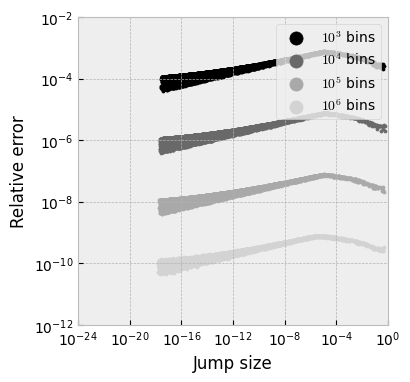

In [51]:
plot_errors_and_jump_sizes(jump_sizes, errors_nodec, n_grids, "error_stable_beta_m_1_c_2_s_01_thr_50_nodec.pdf") #

### Gamma Process

In [110]:
num_fits = 100
m = 1
n_grids = [1001, 10001, 100002, 1000001] # 

In [111]:
errors_dec, errors_nodec, errors_approx, jump_sizes = process_errors_and_jump_sizes(num_fits, gamma_process, {"m": m}, n_grids, g_gamma_process, bounds=(0, np.inf), thr=0.5, n_jumps=40, cache=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

#### Relative jump size errors for the gamma process with provided decomposition

$ e = |S_{\text{dec}} - S_{\text{FK}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

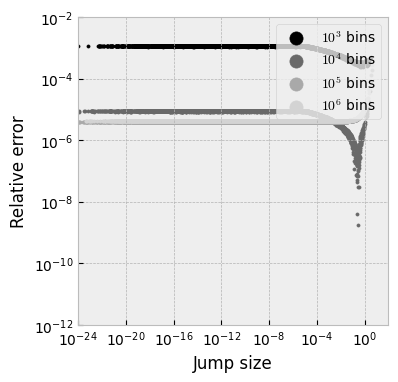

In [84]:
plot_errors_and_jump_sizes(jump_sizes, errors_dec, n_grids, "error_gamma_m_1_thr_50_dec.pdf", None) #

#### Relative jump size errors for the gamma process without provided decomposition

$ e = |S_{\text{FK}} - S_{\text{nodec}}| / S_{\text{FK}}$

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

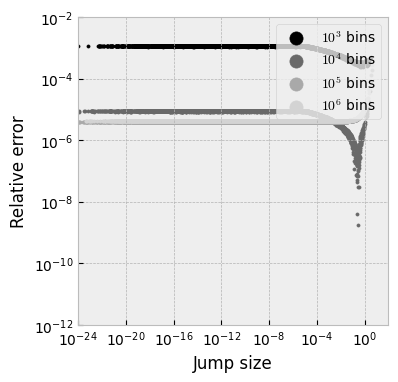

In [85]:
plot_errors_and_jump_sizes(jump_sizes, errors_nodec, n_grids, "error_gamma_m_1_thr_50_nodec.pdf", None) #

### Non-polynomially dominated around 0 processes

$ \nu(x) = m \left( x \log(1/x + 1) \right)^{-1} (1-x)$

In [100]:
def process(m):
    return lambda x: m * (x * np.log(1/x + 1))**(-1) * (1 - x)

In [101]:
num_fits = 100
m = 1
n_grids = [1001, 10001, 100001, 1000001] # 

In [108]:
errors_dec, errors_nodec, errors_approx, jump_sizes = process_errors_and_jump_sizes(num_fits, process, {"m": m}, n_grids, g_process=None, use_trap=True, thr=0.5, n_jumps=500, cache=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

D:\dev\bayes-crm\crm\fk.py:45: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return t - quad(p_x, x, lim, limit=1000000)[0]  # noqa: B023


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

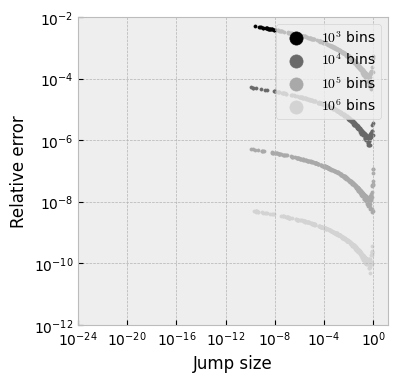

In [109]:
plot_errors_and_jump_sizes(jump_sizes, errors_nodec, n_grids, "error_bespoke_m_1_thr_50_nodec.pdf", None) #

## Error Poisson process rate

The number of points that should be thinned $\sum_{k=1}^{\infty} S_k$ is Poisson distributed with mean $\int_0^{\infty} \left[ \phi(x) - \nu(x) \right] \d x$, where $\phi(x) > \nu(x)$ is defined piece-wise by our approximation to $\nu(x)$.

In [82]:
bounds = (1e-10, 1)

### Error as a function of mass

#### Beta Process

In [83]:
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
trapezium_poi, mixed_poi = process_error_rate_vs_params([1001], {"m": ms, "c": cs}, beta_process, g_beta_process, bounds=bounds)

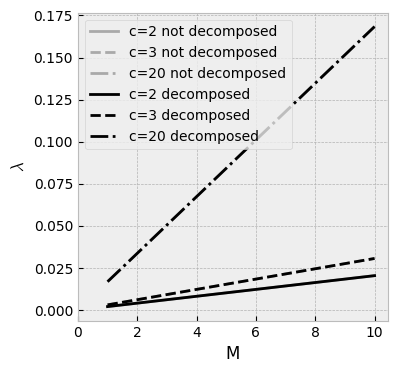

In [85]:
plot_beta_process_err_rate_vs_m(None, ms, cs, trapezium_poi, mixed_poi, "beta_poi_rate.pdf")

#### Stable Beta Process

In [86]:
sigmas = [0.1, 0.3, 0.9]
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
thresholds = [0.8]
trapezium_poi, mixed_poi = process_error_rate_vs_params([1001], {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds, bounds=bounds)

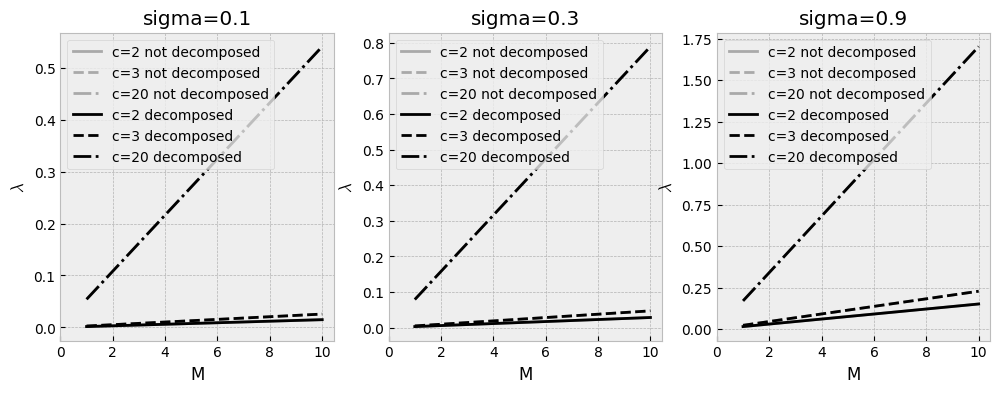

In [87]:
plot_beta_process_err_rate_vs_m(sigmas, ms, cs, trapezium_poi, mixed_poi, "stable_beta_poi_rate_1k_thr80.pdf")

### Error as a function of number of bins
In here, we check how $\sum_{k=1}^{\infty} S_k$ with the number of grid points. 

WARNING: this is a very computationally intensive seciotn. The run time can be 4+ hours.

#### Stable Beta

In [97]:
sigmas = [0.1, 0.3, 0.9]
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001] # 
thresholds = [0.8]

stable_beta_error_nodec, stable_beta_error_dec = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds)

  0%|          | 0/36 [00:00<?, ?it/s]

##### Decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:382: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[i].set_xlim(0, None)


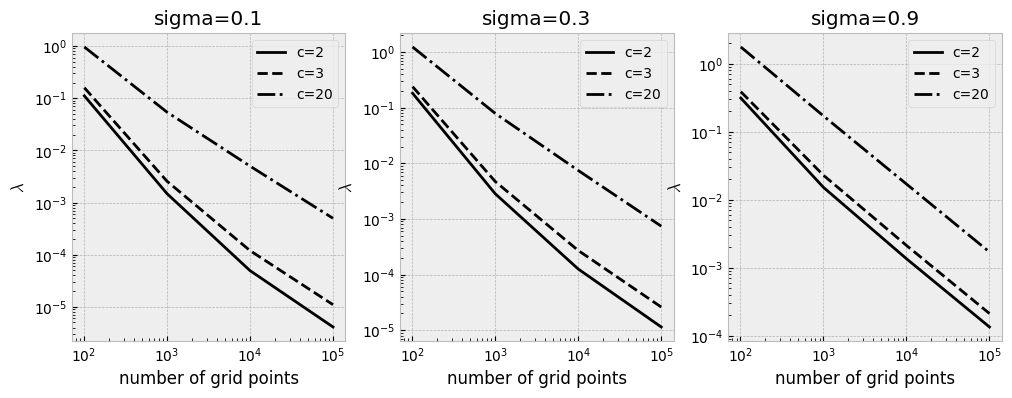

In [98]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_error_nodec, filename="stable_beta_poi_rate_trap_error_bin_count_thr_80_dec.pdf")

##### Not decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:382: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[i].set_xlim(0, None)


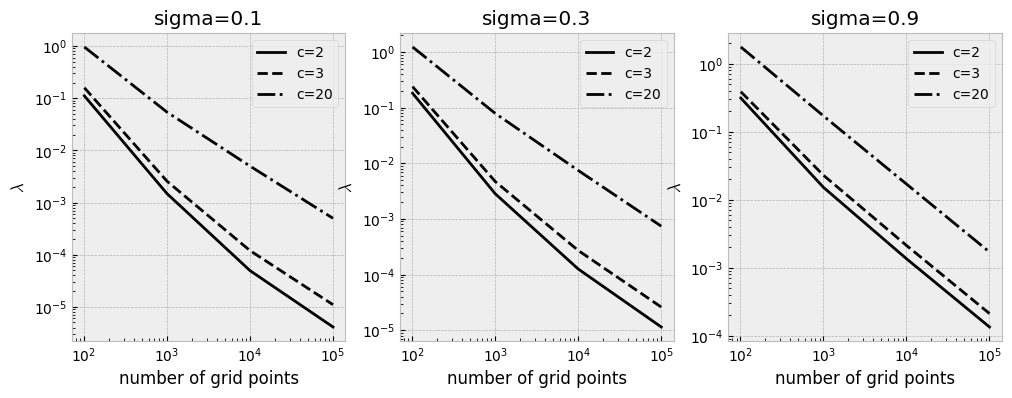

In [99]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_error_dec, filename="stable_beta_poi_rate_mixed_error_bin_count_thr_80_nodec.pdf")

#### Beta

In [89]:
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001]
thresholds = [0.5]

beta_error_nodec, beta_error_dec = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

  0%|          | 0/12 [00:00<?, ?it/s]

##### Decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:400: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


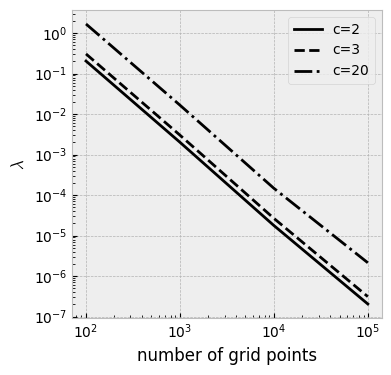

In [90]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_dec, filename="beta_poi_rate_mixed_error_bin_count_thr_50_dec.pdf")

##### Not decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:400: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


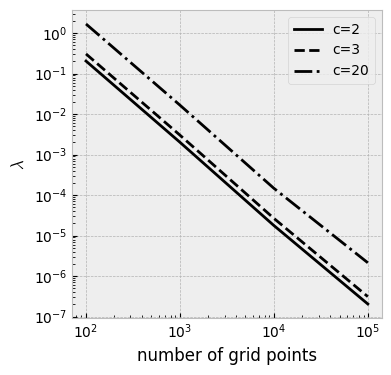

In [91]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_nodec, filename="beta_poi_rate_mixed_error_bin_count_thr_50_nodec.pdf")

In [92]:
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001]
thresholds = [0.8]

beta_error_nodec, beta_error_dec = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

  0%|          | 0/12 [00:00<?, ?it/s]

##### Decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:400: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


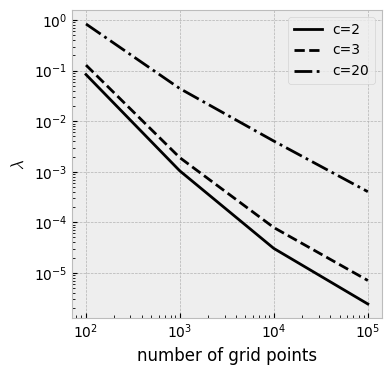

In [94]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_dec, filename="beta_poi_rate_mixed_error_bin_count_thr_80_dec.pdf")

##### Not decomposed intensity

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:400: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


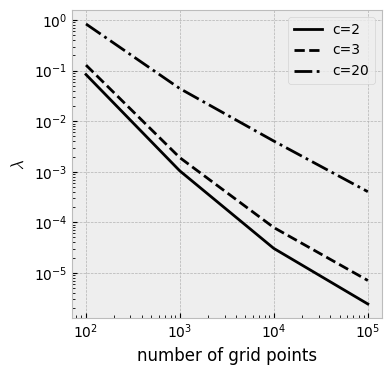

In [96]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_nodec, filename="beta_poi_rate_mixed_error_bin_count_thr_80_nodec.pdf")

### Error rate vs threshold

For the mixed method it is interesting to see how the error rate changes with the threshold which marks where we use the power approximation and where we use the trapezium method.


WARNING: this is a very computationally intensive seciotn. The run time can be 4+ hours.

#### Stable Beta Process

In [33]:
sigmas = [0.1, 0.3, 0.9]
ms = [1]
cs = [2, 3, 20]
num_edges = [1001, 10001, 100001] # 
thresholds = list(np.linspace(0.1, 0.9, 9))


stable_beta_error_trap_thr, stable_beta_error_mixed_thr = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds)

  0%|          | 0/243 [00:00<?, ?it/s]

##### $c = 2$

(None, <Axes: xlabel='$x_{\\text{thr}}$', ylabel='$\\lambda$'>)

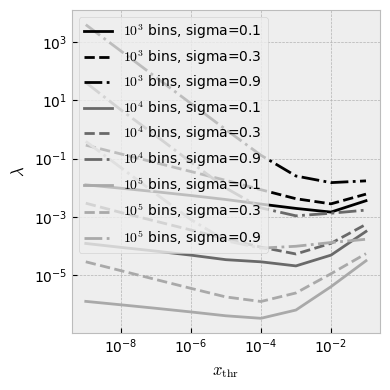

In [38]:
plot_error_vs_threshold_s(stable_beta_error_mixed_thr, num_edges, thresholds, sigmas, "stable_beta_process_mixed_error_sigma_thr.pdf")

##### $\sigma = 0.1$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

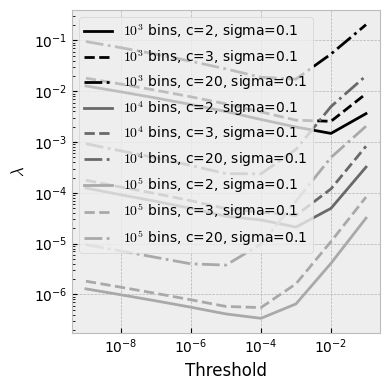

In [39]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas, 0,"stable_beta_process_mixed_error_sigma_01_thr.pdf")

##### $\sigma = 0.3$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

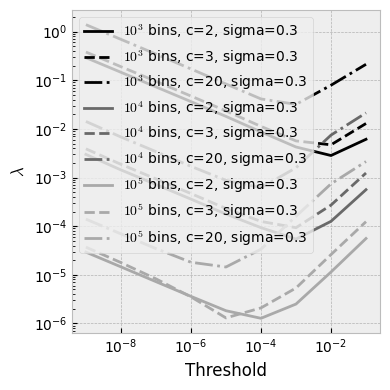

In [42]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas, 1, "stable_beta_process_mixed_error_sigma_03_thr.pdf")

#### $\sigma = 0.9$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

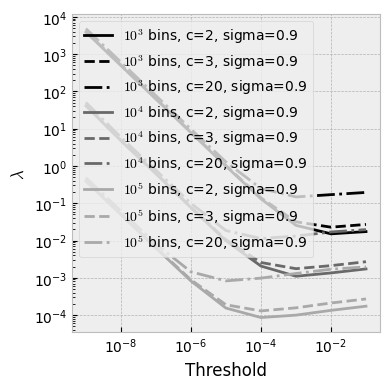

In [43]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas,2, "stable_beta_process_mixed_error_sigma_09_thr.pdf")

#### Beta Process

In [44]:
%%time
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
num_edges = [1001, 10001, 100001] # 
thresholds = list(np.linspace(0.1, 0.9, 9))

beta_error_trap_thr, beta_error_mixed_thr = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

  0%|          | 0/486 [00:00<?, ?it/s]

CPU times: total: 3.58 s
Wall time: 2h 47min 3s


(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

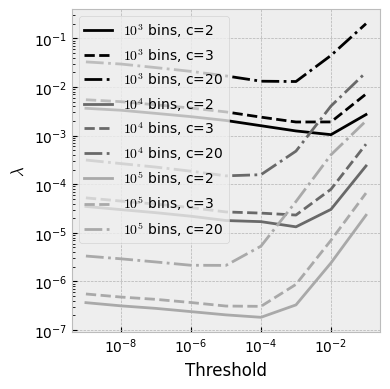

In [45]:
plot_error_vs_threshold_c(beta_error_mixed_thr, num_edges, thresholds, cs, "beta_process_mixed_error_c_thr.pdf")

# Examples

## Example 1

In [3]:
c = 20
alpha = 2
M = 1
mixture_p = lambda x: M * c * x ** (-1) * (1 - x) ** (c - 1) + M * (
    c * (c - 1) / alpha
) * (1 - x) ** (c - 2)

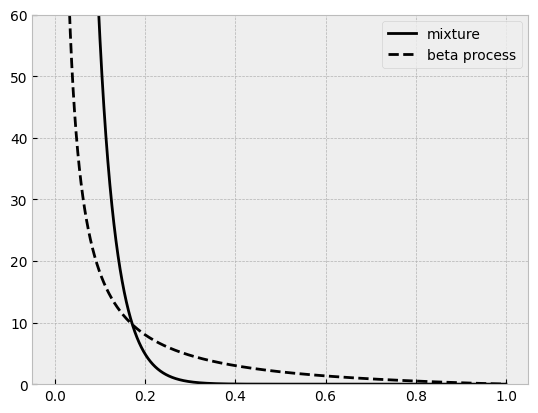

In [4]:
# plotting the intensity functions - the mixture (cont. line) and the beta process (dashed line)
fig, ax = plt.subplots()
xs = np.linspace(0 + 1e-6, 1, 1000000)
ax.plot(xs, mixture_p(xs), c="black", label="mixture")
ax.plot(xs, beta_process(1, 2)(xs), c="black", ls="--", label="beta process")
ax.set_ylim(0, 60)
ax.legend()
plt.show()

In [5]:
cs = [2, 3, 20]
ms = [1, 2, 3, 5, 7, 10]
alphas = [1, 2, 3, 10]

In [ ]:
num_fits = 100
res_num = {}
res_fk = {}

for alpha in tqdm(alphas):
    res_fk[alpha] = {}
    res_num[alpha] = {}
    for c in cs:
        res_num[alpha][c] = {}
        res_fk[alpha][c] = {}
        for M in ms:
            res_fk[alpha][c][M] = measure_time_process(ferguson_klass, num_fits, mixture_p)
            res_num[alpha][c][M] = measure_time_approx_process(10*num_fits, mixture_p, 1001)

(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: title={'center': '$\\xi=$1'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$2'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$3'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$10'}, xlabel='M', ylabel='Speed ratio'>],
       dtype=object))

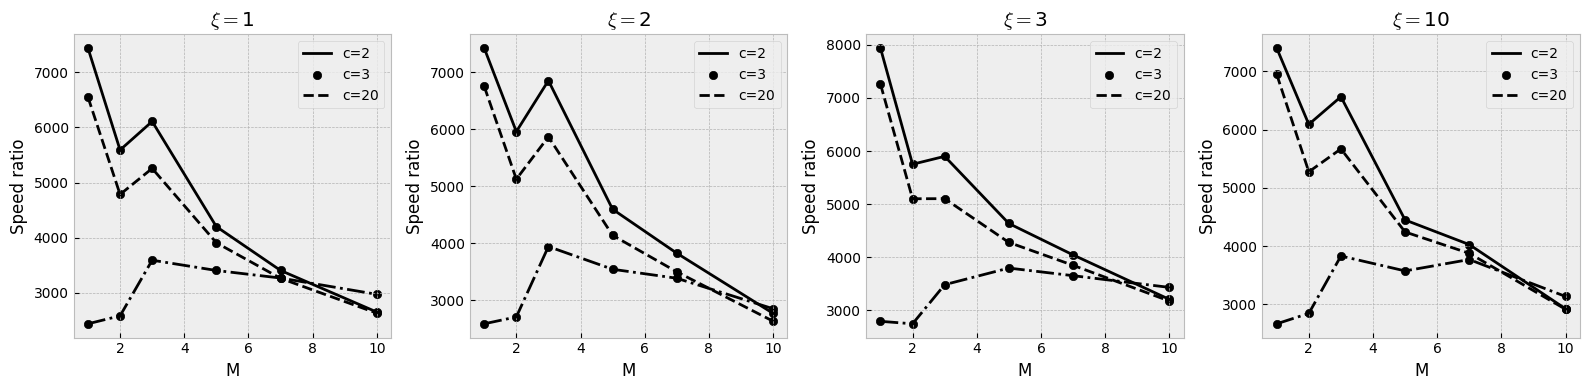

In [ ]:
def plot_data_example(alphas, ms, cs, res_fk, res_num, filename=None):
    """
    This function plots the ratio of execution times of two methods for different parameters.
    
    Args:
        alphas (list): List of alpha values to be plotted.
        ms (list): List of m values to be plotted.
        cs (list): List of c values to be plotted.
        res_fk (dict): Nested dictionary with execution times of the first method. 
                       The keys are alpha, c, and m values in this order.
        res_num (dict): Nested dictionary with execution times of the second method. 
                        The keys are alpha, c, and m values in this order.

    Returns:
        None. The function shows a plot as a side effect.
    """
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for j, a in enumerate(alphas):
        for i, c in enumerate(cs):
            data = np.array([res_fk[a][c][m] for m in ms]) / np.array([res_num[a][2][m] for m in ms])
            linestyle = "-" if i == 0 else "--" if i == 1 else "-."
            axs[j].plot(ms, data, c="black", ls=linestyle)
            axs[j].scatter(ms, data, c="black")
        axs[j].legend([f"c={c}" for c in cs])     
        axs[j].set_title(r"$\xi=$" + str(a))
        axs[j].set_xlabel("M")
        axs[j].set_ylabel("Speed ratio")
    plt.tight_layout()    
    if filename:
        fig.savefig(filename, bbox_inches="tight")
    
    return fig, axs

# Usage
plot_data_example(alphas, ms, cs, res_fk, res_num, "example_1.pdf");

## Occupancy model

In [19]:
from crm.models.occupancy_model import OccupancyModel, predictive

### Sample posteriors

In [20]:
np.random.seed(2)
m = 1
c = 2
theta_1 = 0.6
q_1 = 0.2
n = 10
K = 5
prior_theta = beta_process(m, c)
prior_q = st.beta(2, 2).pdf

In [21]:
Z = np.random.binomial(n=1, p=theta_1, size=n)

In [22]:
Y = np.random.binomial(n=1, p=Z * np.ones((K, n)) * q_1)

In [23]:
om = OccupancyModel(prior_theta, prior_q, n, K)

In [24]:
%%time
theta_posterior, q_cond_posterior = om.posterior(Y)
un_theta_posterior, un_q_cond_posterior = om.posterior(np.zeros(Y.shape))

CPU times: total: 750 ms
Wall time: 944 ms


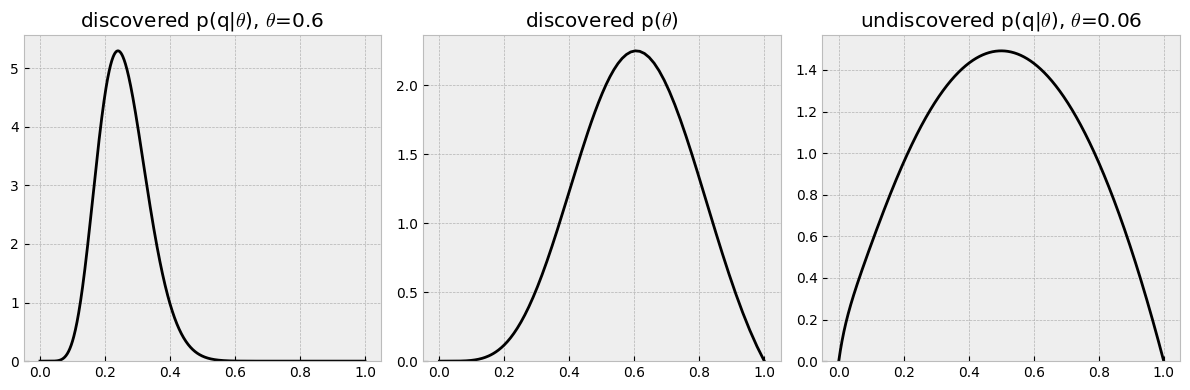

In [25]:
def plot_data(ax, x, y, title):
    ax.plot(x, y, c="black")
    ax.set_title(title)
    ax.set_ylim(0, None)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_data(axs[0], om.q_grid, q_cond_posterior(0.6), r"discovered p(q|$\theta$), $\theta$=0.6")
plot_data(axs[1], om.theta_grid, theta_posterior, r"discovered p($\theta$)")
plot_data(axs[2], om.q_grid, un_q_cond_posterior(0.06), r"undiscovered p(q|$\theta$), $\theta$=0.06")
# plot_data(axs[3], om.theta_grid, un_theta_posterior, r"undiscovered p($\theta$)")

fig.tight_layout()
fig.savefig("occupancy_model_posteriors.pdf", bbox_inches="tight")

### Occupancy model full experiment

In [26]:
m = 1
c = 2
theta_1 = 0.6
q_1 = 0.2
n = 10
K = 5
K_new = 5
prior_theta = beta_process(m, c)
prior_q = st.beta(2, 2).pdf
om = OccupancyModel(prior_theta, prior_q, n, K)

In [27]:
np.random.seed(5)
ap_theta_prior = ApproxProcess(prior_theta, thr=0.8)
probs_theta = ap_theta_prior.generate(size=40)
probs_q = st.beta(2, 2).rvs(size=40)

In [28]:
%%time
n_draws = 10000
y_obs, y_unobs = predictive(om, probs_theta, probs_q, n_draws, n, K, K_new)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 1min 57s
Wall time: 5min 46s


In [29]:
def calculate_unobserved(y_unobs, n_draws, n, K_new):
    n_prev_unobs = np.zeros(n_draws)
    n_prev_unobs_n = {i: np.zeros(n_draws) for i in range(1, n * K_new + 1)}

    for i in range(y_unobs.shape[0]):
        for j in range(n_draws):
            sm = y_unobs[i][j].sum()
            if sm > 0:
                n_prev_unobs[j] += 1
                n_prev_unobs_n[int(sm)][j] += 1

    return n_prev_unobs, n_prev_unobs_n

n_prev_unobs, n_prev_unobs_n = calculate_unobserved(y_unobs, n_draws, n, K_new)

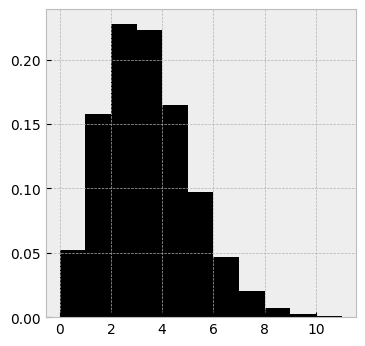

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(
    n_prev_unobs,
    bins=int(n_prev_unobs.max()),
    density=True,
    range=(0, int(n_prev_unobs.max())),
    color="black",
)
fig.savefig("occupancy_model_n_prev_unobs.pdf", bbox_inches="tight")

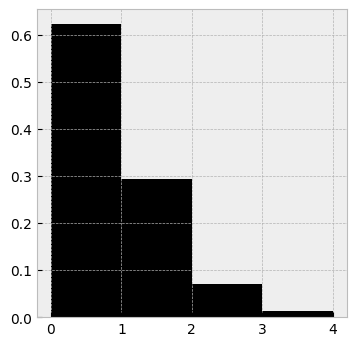

In [32]:
r = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(
    n_prev_unobs_n[r],
    bins=int(n_prev_unobs_n[r].max()),
    density=True,
    range=(0, int(n_prev_unobs_n[r].max())),
    color="black",
)
plt.xticks(np.arange(n_prev_unobs_n[r].min(), n_prev_unobs_n[r].max()+1, 1))
fig.savefig("occupancy_model_n_prev_unobs_r2.pdf", bbox_inches="tight")